In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Ida Puggaard, DTU, s204211@dtu.dk
#   Edited by : Margaret Duff, STFC-UKRI 

# Reconstruction and regularisation for a hyperspectral data set

This notebook will be working with a hyperspectral dataset where 5 materials have been scanned. The materials are: Sugar, H2O2, H2O, Aluminium (10 mm), and PVC (7.8 mm). A picture from when the materials was scanned. The notebook considers 4 different regularisation methods for reconstruction: TV reconstruction for each energy channel, TV reconstruction across both energy and space dimensions and, finally, Tikhonov regularisation across the energy channels and TV reconstruction in the spatial dimensions. 
 



Data can be found at: https://doi.org/10.5281/zenodo.8307932  

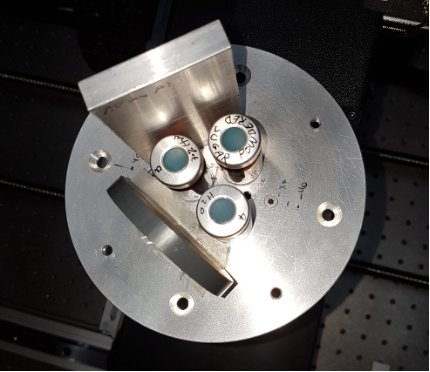

### Tested on CIL version 23.0.1

In [2]:
import cil 
print(cil.__version__)

23.0.1


Imports from CIL: 

In [3]:
import numpy as np                 
import matplotlib.pyplot as plt
import h5py


from cil.optimisation.algorithms import  FISTA, PDHG
from cil.optimisation.functions import LeastSquares, TotalVariation, L2NormSquared, MixedL21Norm, IndicatorBox, BlockFunction

from cil.framework import AcquisitionGeometry


from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D, show_geometry
#from cil.utilities.jupyter import islicer



### Define the scan geometry

In [4]:
#detector parameters
ndet=256                                 # Number of detector pixels, excluding gaps
nElem=2                                  # Number of detector modules
pixel_size=0.077                         # Pixels' size (Pitch)

Sep=0.153                                # Pixels' gap length (cm)
det_space=(ndet)*pixel_size+Sep          # Size of detector in cm (pixels*pixel_size), including the gap

# acquisition parameters
range_angle=360                          # Angular span of projections
nproj=370                                # Number of projections
SDD=115.0                                # Source-Detector distance
sourceCentShift=0                        # Vertical source shift from perfect placement
detectCentShift=0                        # Vertical detector shift from perfect placement
SAD=57.5                                 # Source-AxisOfRotation distance

rot_axis_x = 0                           # x-position of AxisOfRotation
rot_axis_y = 0.0                         # y-position of AxisOfRotation


# Define acquisition geometry
ag = AcquisitionGeometry.create_Cone2D(
    source_position=[sourceCentShift, -SAD],
    detector_position=[detectCentShift, SDD-SAD],
    rotation_axis_position=[rot_axis_x, rot_axis_y])
ag.set_angles(angles=((np.linspace(range_angle,0,nproj, endpoint=False))), angle_unit='degree')
ag.set_panel(num_pixels=[ndet, 1], pixel_size=[pixel_size, pixel_size])
ag.set_channels(128) # Set energy channels
ag.set_labels(['angle', 'horizontal', 'channel'])


Visualising the geometry: 

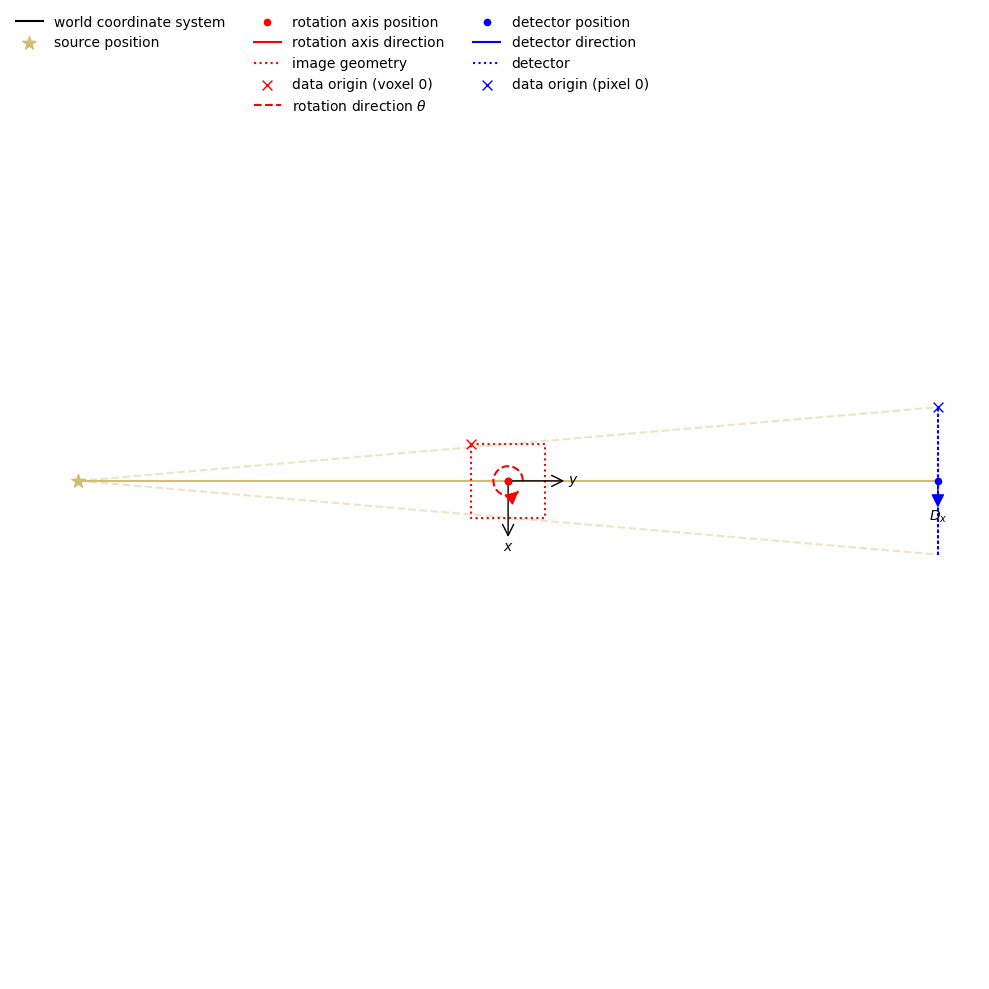

In [5]:
show_geometry(ag)

Load the sinogram data from the sinogram. The sinogram have already been preprossed removing dead/hot pixels and dealing with gaps in the detector.

In [6]:
# Load sinogram using h5 reader
f = h5py.File('sino25_interpol_line.h5','r') 
data_set = np.array(f["data"][:])  

# The sinograms have been preprocessed and more pixels have been added to compensate 
# for a gap in the detector. So the panel size has to be increased.
ag.set_panel(num_pixels=[ndet+2, 1], pixel_size=[pixel_size, pixel_size])

# Change labels to astra ordering.
ag.set_labels(['channel', 'angle', 'horizontal'])

# Look at the data dimensions <channel><angle><horizontal>
print(data_set.shape)

(128, 370, 258)


Putting the data into the CIL class and linking it with the defined geometry.

In [7]:
data = ag.allocate() #allocate space
data.fill(data_set)

# Look at the data info
print(data)

Number of dimensions: 3
Shape: (128, 370, 258)
Axis labels: ('channel', 'angle', 'horizontal')



Obtaining the image geometry

In [8]:
ig=ag.get_ImageGeometry()

# Look at the image geometry info
print(ig)

Number of channels: 128
channel_spacing: 1.0
voxel_num : x258,y258
voxel_size : x0.0385,y0.0385
center : x0,y0



Look at the sinogram for one channel at a time

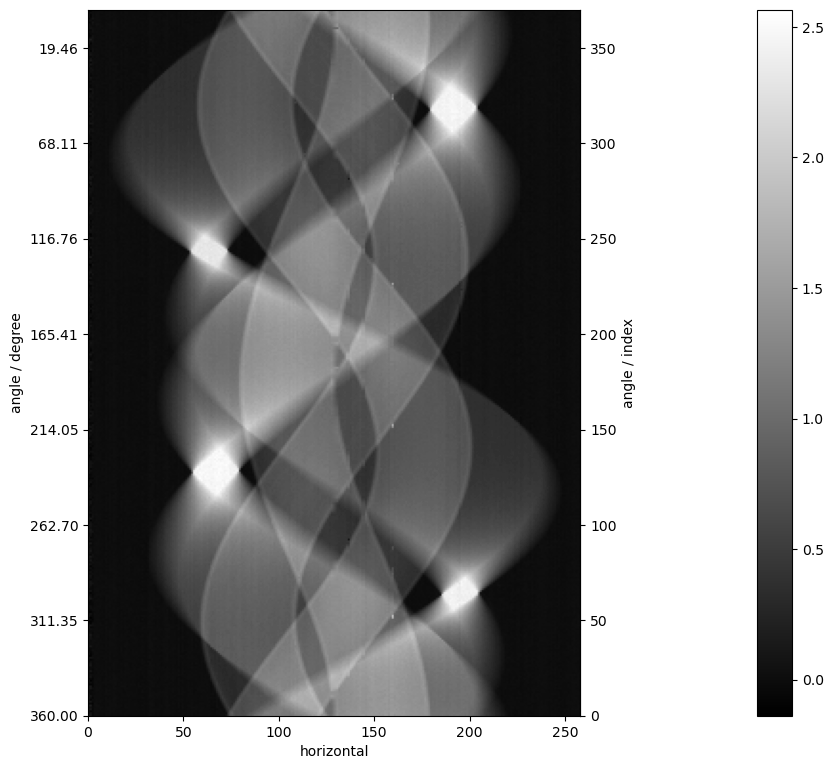

In [9]:
show2D(data.get_slice(channel=64))

We can also visualise the data using the islice function. Note that all the sinograms are all scaled in the same range and therefore lower energy channel sinograms appear brighter than the ones with higher energy levels. This is because the materials have higher attenuation coefficients for lower energy channels. 

In [10]:
#islicer(data)

The attenuation coefficients for the 5 materials can be found using the python library: 'XRay DB' in the energy span: 20.21-153.53 KeV and these are plotted below. In the plot glass is also included since Sugar, H2O2, and H2O are contained inside glass bottles.

The y-axis gives the attenuation coefficients and the x-axis the energy in eV.

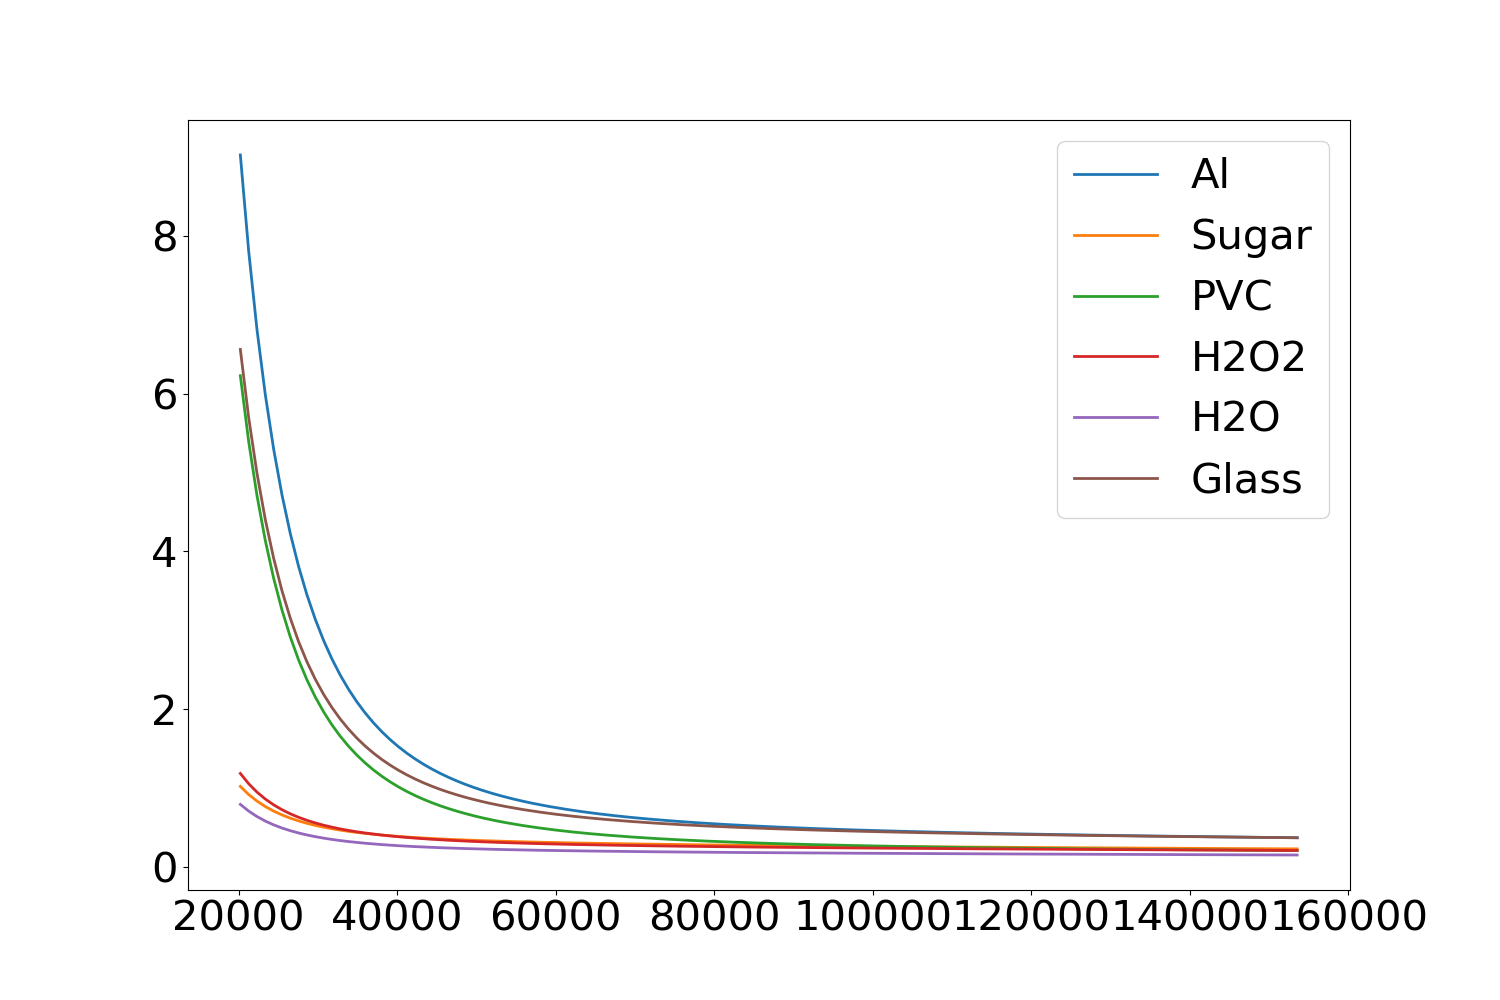

### TV regularisation in space

Firstly, we try to reconstruct the channels separately with TV regularisation. We will use the 
CIL function TotalVariation:
$$\argmin_{x} \frac{1}{2} ||Ax-b||_{2}^{2}+\alpha TV(x).$$

N.B the following cell will take >1hour to run! 

In [11]:
# Allocate space for solution
recon_data=ig.allocate()

# Define projection operator
ag2D=ag.get_slice(channel=0)
ig2D=ag2D.get_ImageGeometry()
A_2D = ProjectionOperator(ig2D, ag2D, 'gpu')

# Loop over all the channels and reconstruct each channel 
for j in range(ig.channels):
    f1 = LeastSquares(A_2D, data.get_slice(channel=j))
    alpha=0.001
    # Totalvariation with non-negative constraint
    TV = alpha*TotalVariation(lower=0)

    myFISTATV_TV = FISTA(f=f1, 
            g=TV, 
            initial=ig2D.allocate(0),
            max_iteration=100, 
            update_objective_interval = 10)
    
    myFISTATV_TV.run(100,verbrose=1)
    recon_data.fill(myFISTATV_TV.solution,channel=j)


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          0.00000e+00
       10        100         0.380          0.00000e+00
       20        100         0.345          0.00000e+00
       30        100         0.331          0.00000e+00
       40        100         0.324          0.00000e+00
       50        100         0.320          0.00000e+00
       60        100         0.316          0.00000e+00
       70        100         0.314          0.00000e+00
       80        100         0.312          0.00000e+00
       90        100         0.309          0.00000e+00
      100        100         0.308          0.00000e+00
-------------------------------------------------------
      100        100         0.308          0.00000e+00
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0     

We can then look at the reconstruction.

In [ ]:
show2D(recon_data.get_slice(channel=63))

We can construct the energy curves from the 5 materials by extracting one pixel from each material and plot the cuvres. 

In [ ]:
solution_arr=recon_data.as_array()
plt.plot(solution_arr[:,50,125],'r',label='Alu')
plt.plot(solution_arr[:,125,150],'m',label='H2O2')
plt.plot(solution_arr[:,200,140],'g',label='pvc')
plt.plot(solution_arr[:,100,100],'c',label='Sugar')
plt.plot(solution_arr[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()

### TV regularisation in across both energy channels and spatial dimensions

We can also use TV regularisation in both the space and the energy dimension by giving the input 'SpaceChannels' to the TotalVariation function. 

In [ ]:
A = ProjectionOperator(ig, ag, 'gpu')
f1 = LeastSquares(A, data)

alpha = 0.001
GTV = alpha*TotalVariation(correlation='SpaceChannels',lower=0)

myFISTATV = FISTA(f=f1, 
                  g=GTV, 
                  initial=ig.allocate(0),
                  max_iteration=100, 
                  update_objective_interval = 10)


myFISTATV.run(100,verbrose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          4.63959e+07
       10        100        44.863          2.87992e+06


KeyboardInterrupt: 

Look at the solution.

In [ ]:
show2D(myFISTATV.solution.get_slice(channel=63))

We can again look at the energy curves and see that the regularisation have had an effect on the curves.

In [ ]:
solution_arr=myFISTATV.solution.as_array()
plt.plot(solution_arr[:,50,125],'r',label='Alu')
plt.plot(solution_arr[:,125,150],'m',label='H2O2')
plt.plot(solution_arr[:,200,140],'g',label='pvc')
plt.plot(solution_arr[:,100,100],'c',label='Sugar')
plt.plot(solution_arr[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()


### TV regularisation in spatial dimensions and Tikhonov regularisation across the energy channels

The regularisation used in the space dimension and the energy dimension does not have to be the same. We can therefore try to use Tikhonov regularisation in the energy dimension instead of TV.
The reasoning is that Tikhonov is good for smoothing compared to TV which is good for maintaining sharp edges. 

$$argmin_{x} \frac{1}{2} ||Ax-b||_{2}^{2}+\alpha TV(x)+\beta || \mathbf{D}_e x ||$$

$ \beta $ is the regularisation parameter for Tikhonov.

In [ ]:
# Use same alpha 
alpha = 0.001 

beta = 0.5

# Projection operationer
A = ProjectionOperator(ig, ag, 'gpu')

# Use the gradient operator to apply the regularisation and plitting it to use different 
# regularisation terms 
Grad2 = GradientOperator(ig, correlation='SpaceChannels',split=True)   
K = BlockOperator(A, Grad2)
splitTik_TV=BlockFunction(beta*0.5*L2NormSquared(), alpha*MixedL21Norm())
f = BlockFunction(0.5*L2NormSquared(b=data),splitTik_TV)
# Non-negative constraint
G = IndicatorBox(lower=0 )

# Use PDHG as solver
num_iter=100
PDHG_Tik_TV = PDHG(f=f, g=G, operator=K, max_iteration=num_iter, update_objective_interval = 10)

PDHG_Tik_TV.run(num_iter,verbose=2)




Show the solution for each channel.

In [ ]:
show2D(PDHG_Tik_TV.solution.get_slice(channel=63))

We can once again look at the energy curves for each material.

In [ ]:
Tik_TV_sol=PDHG_Tik_TV.solution.as_array()

plt.plot(Tik_TV_sol[:,50,125],'r',label='Alu')
plt.plot(Tik_TV_sol[:,125,150],'m',label='H2O2')
plt.plot(Tik_TV_sol[:,200,140],'g',label='pvc')
plt.plot(Tik_TV_sol[:,100,100],'c',label='Sugar')
plt.plot(Tik_TV_sol[:,160,100],'b',label='Water')

plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Attenuation [1/cm]')
extent=np.linspace(21.20,153.53,8)
extent = ["%.2f" % v for v in extent]
plt.xticks(ticks=np.linspace(0,127,8),labels=extent)
plt.show()

It can be seen that the energy curves looks more smooth and closer to the table value curves from xraydb.  